In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
import sys 
import os
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../VasModules')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver


saveFigs = True

In [3]:
from transforms import transforms
from Decon import SpectralDecon
from synthData_Gen import SyntheticData_Gen

# Synthetic data
Illustrating the diffusion process through synthetic data

In [188]:
AR_inst = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = (200**2)*1e-3, AR1_dt = 0.001, AR1_N = 20000, diff_len = 0.07, dt_sample = 0.02, meas_noise = 0.07*1e-3)

In [189]:

zAR1, xAR1 = AR_inst.synthetic_AR1()
z, x, zAR1_dt, xAR1_dt, zConv, xConv = AR_inst()

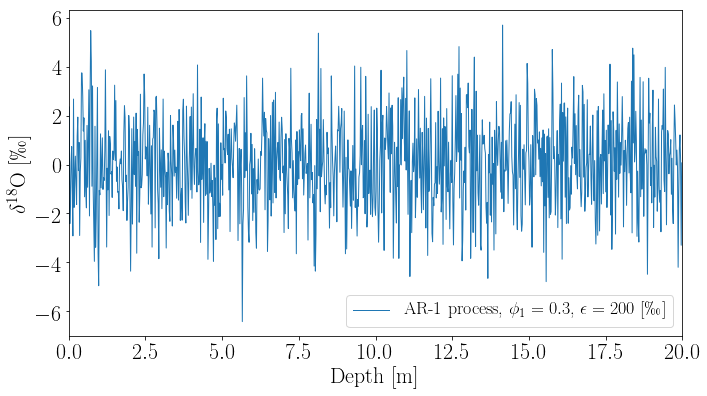

In [322]:
fig, ax = plt.subplots(figsize=(11,6))

ax.plot(zAR1_dt, xAR1_dt, lw=1, label = 'AR-1 process, $\phi_1 = 0.3$, $\epsilon = 200$ [\permil]')

ax.set(xlim=(min(zAR1), max(zAR1)), xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]')

ax.legend(fontsize=18)

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'AR1_process.png', bbox_inches='tight')

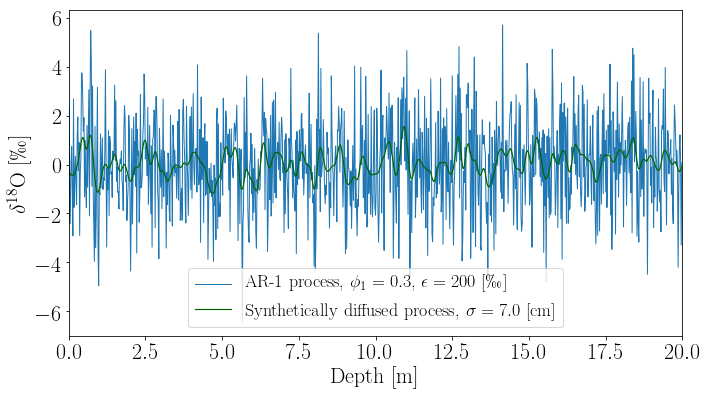

In [324]:
fig, ax = plt.subplots(figsize=(11,6))

ax.plot(zAR1_dt, xAR1_dt, lw=1, label = 'AR-1 process, $\phi_1 = 0.3$, $\epsilon = 200$ [\permil]')
ax.plot(zConv, xConv, lw=1.2, c='darkgreen', label = 'Synthetically diffused process, $\sigma = 7.0$ [cm]')
ax.set(xlim=(min(zAR1), max(zAR1)), xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]')

ax.legend(fontsize=18, loc='lower center')

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'AR1_process_W_backDiff.png', bbox_inches='tight')

In [314]:
N = 500
dt = (zAR1_dt[1] - zAR1_dt[0])

ffts = sp.fft.fft(xAR1_dt, n = 2*N, norm='ortho')
ws = np.fft.fftfreq(2*N, dt)[:(2*N)//2]

psd = abs(ffts[np.where(ws >= 0)])**2
w = ws[np.where(ws >= 0)]

In [315]:
N2 = 500
dt2 = (zConv[1] - zConv[0])

ffts2 = sp.fft.fft(xConv, n = 2*N2, norm='ortho')
ws2 = np.fft.fftfreq(2*N2, dt2)[:(2*N2)//2]

psd2 = abs(ffts2[np.where(ws2 >= 0)])**2
w2 = ws2[np.where(ws2 >= 0)]

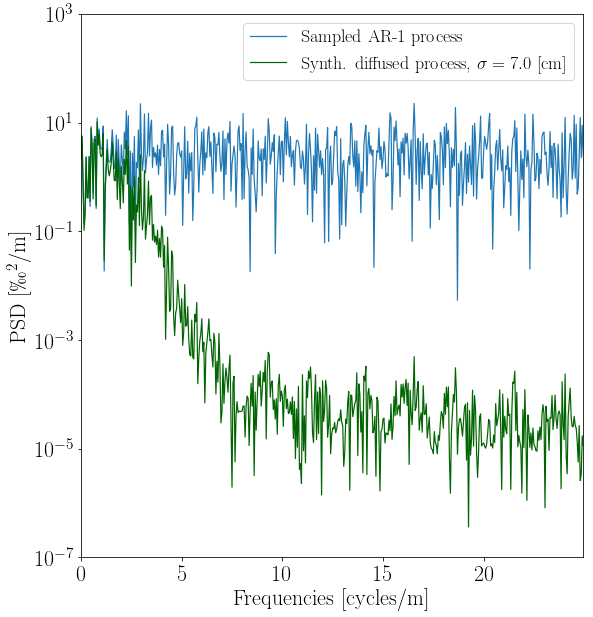

In [503]:
fig, ax = plt.subplots(figsize=(9,10))
ax.semilogy(w,psd, lw=1.2, label = 'Sampled AR-1 process')
ax.semilogy(w2,psd2, lw=1.2, c='darkgreen', label = 'Synth. diffused process, $\sigma = 7.0$ [cm]')

ax.set(ylim = (1e-7, 1e3), xlabel = 'Frequencies [cycles/m]', ylabel = 'PSD [\permil$^2$/m]', xlim=(min(w),max(w)))
ax.legend(fontsize=18, loc = 'upper right')

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'AR1_process_W_backDiff_PSD.png', box_inches='tight')

# Comparing spectral transforms
Comparing FFT, NFFT, DCT and NDCT

In [4]:
sites = ['B19','B22','B23','SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInts = [33, 33, 33, 33, 33, 33]
Nt_InInts = [33, 33, 33, 33, 33, 33]

j = 3

site = sites[j]
N_InInt = N_InInts[j]

N_InInt_test = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth'][1:]
d18O = data_d18O['d18O'][1:]
depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

depthECM = data_ECM['depth']
ECM = data_ECM['ECM']
depthECM_LT = data_ECM_LT['depth']
ECM_LT = data_ECM_LT['ECM']


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-4-4ad2e39edeb4>:25: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet') #'AWI_Bcores'


In [5]:
from Decon import SpectralDecon

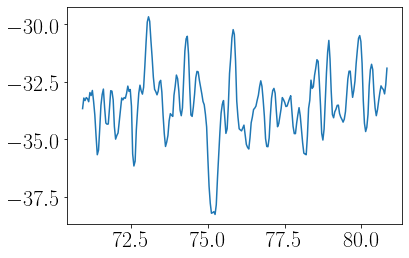

In [6]:
depth = np.asarray(depth_LT)
d18O = np.asarray(d18O_LT)

plt.plot(depth, d18O)

In [7]:
instFFT = SpectralDecon(depth, d18O, 2000, 'FFT')
instDCT = SpectralDecon(depth, d18O, 2000, 'DCT')
instNDCT = SpectralDecon(depth, d18O, 2000, 'NDCT')

In [8]:
fS_fft, S_fft, _ = instFFT.fft()
S_fft = np.real(S_fft[np.where(fS_fft >= 0)])
fS_dct, S_dct = instDCT.dct()
fS_ndct, S_ndct = instNDCT.Ndct()



f_fft, PSD_fft = instFFT.dct_psd()
f_dct, PSD_dct = instDCT.dct_psd()
f_ndct, PSD_ndct = instNDCT.dct_psd()



### Transforms only

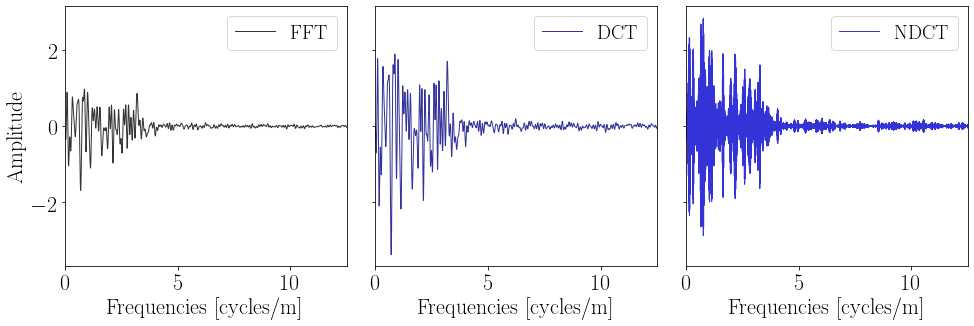

In [18]:
fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)


ax[0].plot(fS_fft[1:], S_fft[1:], 'k', lw=1, alpha=0.8, label = 'FFT')
ax[1].plot(fS_dct[1:], S_dct[1:], 'navy', alpha = 0.8, lw=1, label = 'DCT')
ax[2].plot(fS_ndct[1:], S_ndct[1:], 'mediumblue', alpha=0.8, lw=1, label = 'NDCT')

ax[0].set(xlim=(min(f_fft), max(f_fft))); ax[0].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[0].set_ylabel('Amplitude', fontsize=22); ax[0].legend(fontsize=20)
ax[1].set(xlim=(min(f_fft), max(f_fft))); ax[1].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[1].legend(fontsize=20)
ax[2].set(xlim=(min(f_fft), max(f_fft))); ax[2].set_xlabel('Frequencies [cycles/m]', fontsize=22); ax[2].legend(fontsize=20)
fig.tight_layout()

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'SpectralTransforms_3.pdf', box_inches='tight')

### PSDs

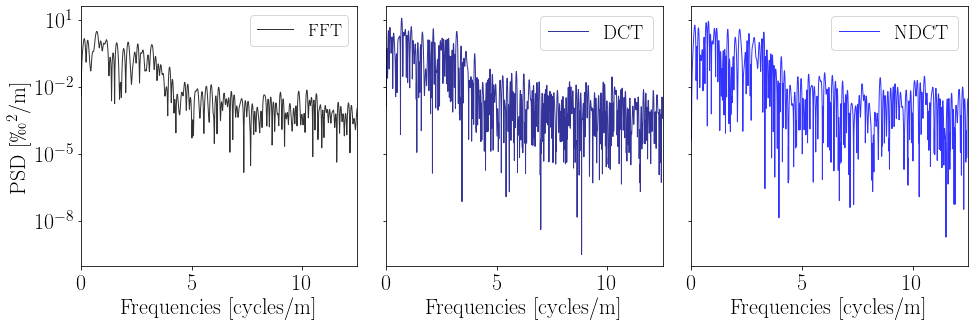

In [23]:
fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)

ax[0].semilogy(f_fft[1:], PSD_fft[1:], 'k', lw=1, alpha=0.8, label = 'FFT')
ax[1].semilogy(f_dct[1:], PSD_dct[1:], 'navy', alpha = 0.8, lw=1, label = 'DCT')
ax[2].semilogy(f_ndct[1:], PSD_ndct[1:], 'b', alpha=0.8, lw=1, label = 'NDCT')

ax[0].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]', ylabel = 'PSD [$\permil$$^2$/m]'); ax[0].legend(fontsize=18)
ax[1].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]'); ax[1].legend(fontsize=20)
ax[2].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]'); ax[2].legend(fontsize=20)
fig.tight_layout()

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'SpectralTransforms_PSD.pdf', box_inches='tight')

In [24]:
fit_fft = instFFT.SpectralFit()
fit_dct = instDCT.SpectralFit()
fit_ndct = instNDCT.SpectralFit()

Fit Parameters:

P0 = 0.431433608330396
Var = 0.1768112112678017
s_eta2 = 0.1768112112678017 m
Diff len = 7.545860585489882 cm
a1 = 0.4
Diff. len., fit [cm]: 7.546
Fit Parameters:

P0 = 0.5506230901922323
Var = 0.17329337164137243
s_eta2 = 0.17329337164137243 m
Diff len = 7.832703398889302 cm
a1 = 0.4
Diff. len., fit [cm]: 7.833
Fit Parameters:

P0 = 0.49146250165299277
Var = 0.1873181060220256
s_eta2 = 0.1873181060220256 m
Diff len = 7.735265813583965 cm
a1 = 0.4
Diff. len., fit [cm]: 7.735


In [25]:
w_fft, P_fft, Pnoise_fft, Psignal_fft, P_fit_fft, opt_fit_dict_fft, _, _, _ = fit_fft
w_dct, P_dct, Pnoise_dct, Psignal_dct, P_fit_dct, opt_fit_dict_dct, _, _, _ = fit_dct
w_ndct, P_ndct, Pnoise_ndct, Psignal_ndct, P_fit_ndct, opt_fit_dict_ndct, _, _, _ = fit_ndct

In [26]:
sigma_fft = opt_fit_dict_fft['s_tot2_fit']
sigma_dct = opt_fit_dict_dct['s_tot2_fit']
sigma_ndct = opt_fit_dict_ndct['s_tot2_fit']

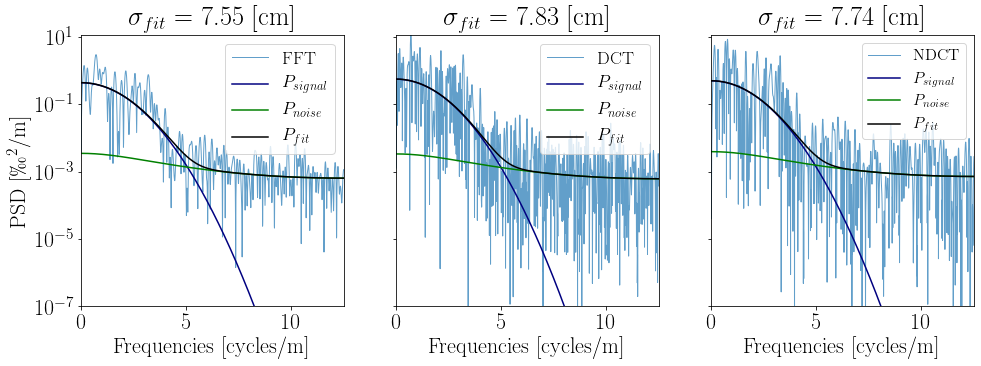

In [32]:
fig, ax = plt.subplots(1,3,figsize=(16,5), sharey=True)

ax[0].semilogy(f_fft[1:], PSD_fft[1:], 'C0', lw=1, alpha=0.7, label = 'FFT')
ax[0].semilogy(w_fft, Psignal_fft, lw=1.5, c='navy', label = '$P_{signal}$')
ax[0].semilogy(w_fft, Pnoise_fft, lw=1.5, c='green', label = '$P_{noise}$')
ax[0].semilogy(w_fft, P_fit_fft, lw=1.5, c='k', label = '$P_{fit}$')
ax[0].set(xlim=(min(f_fft), max(f_fft)), ylim=(1e-7, max(PSD_dct)), xlabel = 'Frequencies [cycles/m]', ylabel = 'PSD [$\permil$$^2$/m]', title = '$\sigma_{fit} = $'+f' {sigma_fft*100:.2f} [cm]')
ax[0].legend(fontsize=18, loc = 'upper right')


ax[1].semilogy(f_dct[1:], PSD_dct[1:], 'C0', alpha = 0.7, lw=1, label = 'DCT')
ax[1].semilogy(w_dct, Psignal_dct, lw=1.5, c='navy', label = '$P_{signal}$')
ax[1].semilogy(w_dct, Pnoise_dct, lw=1.5, c='green', label = '$P_{noise}$')
ax[1].semilogy(w_dct, P_fit_dct, lw=1.5, c='k', label = '$P_{fit}$')
ax[1].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]', title = '$\sigma_{fit} = $'+f' {sigma_dct*100:.2f} [cm]')
ax[1].legend(fontsize=18, loc = 'upper right')


ax[2].semilogy(f_ndct[1:], PSD_ndct[1:], 'C0', alpha=0.7, lw=1, label = 'NDCT')
ax[2].semilogy(w_ndct, Psignal_ndct, lw=1.5, c='navy', label = '$P_{signal}$')
ax[2].semilogy(w_ndct, Pnoise_ndct, lw=1.5, c='green', label = '$P_{noise}$')
ax[2].semilogy(w_ndct, P_fit_ndct, lw=1.5, c='k', label = '$P_{fit}$')
ax[2].set(xlim=(min(f_fft), max(f_fft)), xlabel = 'Frequencies [cycles/m]', title = '$\sigma_{fit} = $'+f' {sigma_ndct*100:.2f} [cm]')
ax[2].legend(fontsize=16, loc = 'upper right')



fig.tight_layout

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/'+'SpectralTransforms_PSDwFits.pdf', box_inches='tight')